In [1]:
import pandas as pd

# Step 1: Load the dataset
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)

# Step 2: Show basic info about the dataset
print(df.info())
print(df.head())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


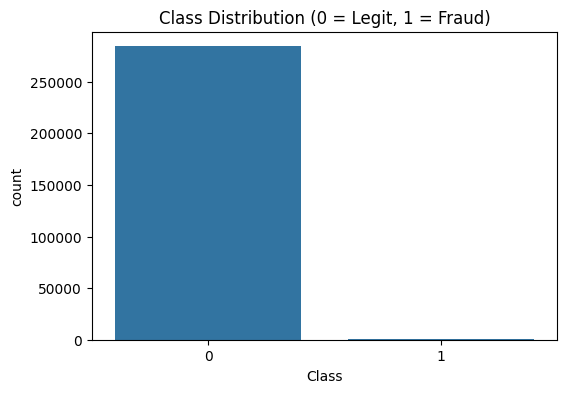

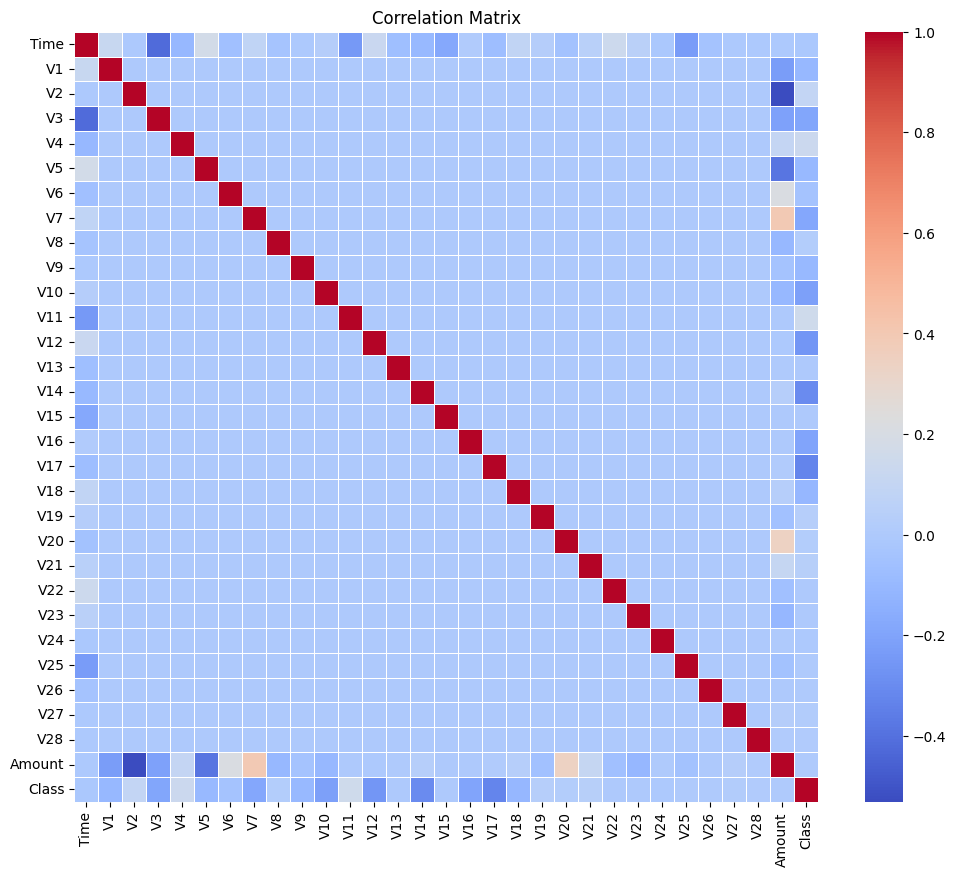

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
print("Class distribution:\n", df['Class'].value_counts())

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.show()

# Plot correlations (optional heavy computation)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Drop any rows with NaN values (just in case)
df_cleaned = df.dropna()

# Step 2: Separate features and target
X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Confirm new balance
print("After SMOTE, class distribution:\n", pd.Series(y_train_resampled).value_counts())


After SMOTE, class distribution:
 Class
0    227451
1    227451
Name: count, dtype: int64


In [4]:
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

# Use part of your actual data
X_real = X.to_numpy()
y_real = y.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_real)

# We'll simplify by treating each row as state index
q_table = np.zeros((len(X_scaled), 2))  # 2 actions: 0 = legit, 1 = fraud

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1  # One pass over the dataset (feel free to increase)

# Reward function
def reward_fn(true_label, predicted_action):
    if true_label == predicted_action:
        return 10 if true_label == 1 else 5
    return -10

# Q-Learning over actual transactions
for episode in range(episodes):
    for i in range(len(X_scaled)):
        state = i
        label = y_real[i]

        if random.random() < epsilon:
            action = random.choice([0, 1])
        else:
            action = np.argmax(q_table[state])

        reward = reward_fn(label, action)
        next_state = (i + 1) % len(X_scaled)

        q_table[state, action] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )

print("📘 Final Real-State Q-Table (sample):")
print(q_table[:10])  # Display first 10 states for review


📘 Final Real-State Q-Table (sample):
[[0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]
 [0.5 0. ]]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Environment: Each row is a state (transaction), goal is to predict fraud
class FraudEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.index = 0
        self.n_samples = len(y)

    def reset(self):
        self.index = 0
        return self.X[self.index]

    def step(self, action):
        label = self.y[self.index]
        reward = 10 if action == label else -10
        self.index += 1
        done = self.index >= self.n_samples
        next_state = self.X[self.index] if not done else None
        return next_state, reward, done

# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Two actions: legit or fraud
        )

    def forward(self, x):
        return self.fc(x)


In [7]:
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        if random.random() < epsilon:
            action = random.randint(0, 1)
        else:
            with torch.no_grad():
                action = model(state_tensor).argmax().item()

        next_state, reward, done = env.step(action)
        total_reward += reward
        memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Fix for tensor conversion
            states = torch.FloatTensor(np.array(states))
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            dones_tensor = torch.BoolTensor(dones).unsqueeze(1)

            # Handle non-final next states properly
            non_final_next_states = [s for s, d in zip(next_states, dones) if not d]
            non_final_mask = ~dones_tensor.squeeze()

            next_q_vals = torch.zeros(batch_size, 1)
            if len(non_final_next_states) > 0:
                non_final_next_states_tensor = torch.FloatTensor(np.array(non_final_next_states))
                max_q_next = model(non_final_next_states_tensor).max(1)[0].detach().unsqueeze(1)
                next_q_vals[non_final_mask] = max_q_next

            q_vals = model(states).gather(1, actions)
            targets = rewards + gamma * next_q_vals

            loss = criterion(q_vals, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    print(f"📈 Episode {episode + 1} | Total Reward: {total_reward}")


📈 Episode 1 | Total Reward: 2690
📈 Episode 2 | Total Reward: 15470
📈 Episode 3 | Total Reward: 26930
📈 Episode 4 | Total Reward: 39110
📈 Episode 5 | Total Reward: 53430
📈 Episode 6 | Total Reward: 64050
📈 Episode 7 | Total Reward: 86490
📈 Episode 8 | Total Reward: 103090
📈 Episode 9 | Total Reward: 118390
📈 Episode 10 | Total Reward: 138310


In [8]:
# Prepare test data
X_test_np = scaler.transform(X_test.to_numpy().astype(np.float32))
y_test_np = y_test.to_numpy()

correct = 0
total = 0

for i in range(len(X_test_np)):
    state_tensor = torch.FloatTensor(X_test_np[i]).unsqueeze(0)
    with torch.no_grad():
        action = model(state_tensor).argmax().item()
    total += 1
    correct += (action == y_test_np[i])

accuracy = correct / total
print(f"✅ DQN Agent Accuracy on Test Set: {accuracy:.4f}")


✅ DQN Agent Accuracy on Test Set: 0.9994


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_pred_dqn = []
for i in range(len(X_test_np)):
    state_tensor = torch.FloatTensor(X_test_np[i]).unsqueeze(0)
    with torch.no_grad():
        action = model(state_tensor).argmax().item()
    y_pred_dqn.append(action)

# Print evaluation
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_dqn))

print("📄 Classification Report:")
print(classification_report(y_test_np, y_pred_dqn, digits=4))


📊 Confusion Matrix:
[[56851    13]
 [   24    74]]
📄 Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8506    0.7551    0.8000        98

    accuracy                         0.9994     56962
   macro avg     0.9251    0.8774    0.8998     56962
weighted avg     0.9993    0.9994    0.9993     56962



In [10]:
# Save model weights
torch.save(model.state_dict(), "dqn_model.pth")

# Download from Colab
from google.colab import files
files.download("dqn_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
episode_rewards = []

for episode in range(episodes):
    ...
    episode_rewards.append(total_reward)
    print(f"📈 Episode {episode + 1} | Total Reward: {total_reward}")


📈 Episode 1 | Total Reward: 138310
📈 Episode 2 | Total Reward: 138310
📈 Episode 3 | Total Reward: 138310
📈 Episode 4 | Total Reward: 138310
📈 Episode 5 | Total Reward: 138310
📈 Episode 6 | Total Reward: 138310
📈 Episode 7 | Total Reward: 138310
📈 Episode 8 | Total Reward: 138310
📈 Episode 9 | Total Reward: 138310
📈 Episode 10 | Total Reward: 138310


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


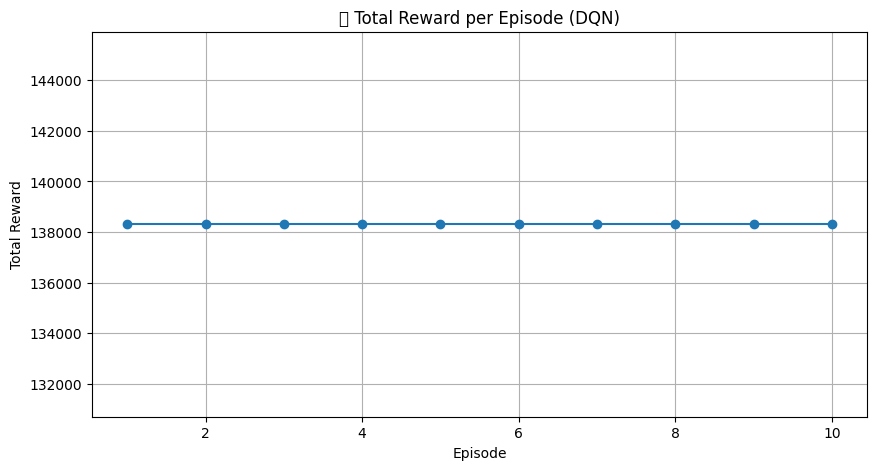

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(episode_rewards)+1), episode_rewards, marker='o')
plt.title("📈 Total Reward per Episode (DQN)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [13]:
# Save classification report to a text file
from sklearn.metrics import classification_report

report = classification_report(y_test_np, y_pred_dqn, digits=4)
with open("dqn_classification_report.txt", "w") as f:
    f.write(report)

# Download it
files.download("dqn_classification_report.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>